### import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import math 

from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble

from sklearn.externals import joblib

import json

import warnings
warnings.filterwarnings('ignore')

### Read in data

In [478]:
Train = pd.read_csv(r'D:\Learn\DoorDash\historical_data.csv')

In [209]:
Train.dtypes

market_id                                              float64
created_at                                              object
actual_delivery_time                                    object
store_id                                                object
store_primary_category                                  object
order_protocol                                         float64
total_items                                            float64
subtotal                                               float64
num_distinct_items                                     float64
min_item_price                                         float64
max_item_price                                         float64
total_onshift_dashers                                  float64
total_busy_dashers                                     float64
total_outstanding_orders                               float64
estimated_order_place_duration                         float64
estimated_store_to_consumer_driving_duration           

In [169]:
Train.shape

(197428, 16)

In [170]:
Train.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
3  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
4  f0ade77b43923b38237db569b016ba25                    NaN             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0            4      3441                   4             557            1239   
1            1      1900                   1            1400            1400   
2            1      1900                   1            1900            1900   
3            6      6900                   5             600            1800   
4            3      3900                   3            1100            1600   

   total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                   33.0                14.0                      21.0   
1                    1.0                 2.0                       2.0   
2                    1.0                 0.0                       0.0   
3                    1.0                 1.0                       2.0   
4                    6.0                 6.0                       9.0   

   estimated_order_place_duration  \
0                             446   
1                             446   
2                             446   
3                             446   
4                             446   

   estimated_store_to_consumer_driving_duration  
0                                         861.0  
1                                         690.0  
2                                         690.0  
3                                         289.0  
4                                         650.0

### Descriptive statistics

In [171]:
def create_summary_table(df):
    
    def num_missing(x):
        return len(x.index)-x.count()
    
    def pct_missing(x):
        return (len(x.index)-x.count())/x.count()

    def num_unique(x):
        return len(x.value_counts(dropna=False))

    # for numerical features
    temp_df = df.describe().T

    missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
    missing_df.columns = ['missing']

    pct_missing_df = pd.DataFrame(df.apply(pct_missing, axis=0))
    pct_missing_df.columns = ['pct_missing']
    
    unq_df = pd.DataFrame(df.apply(num_unique, axis=0))
    unq_df.columns = ['unique']

    types_df = pd.DataFrame(df.dtypes)
    types_df.columns = ['DataType']   

    summary_df_cont = temp_df.join(missing_df).join(pct_missing_df).join(unq_df).join(types_df)
    
    # for Cat features
    col_names = list(Train.columns)
    num_cols = len(col_names)
    index = range(num_cols)
    cat_index = []

    for i in index:
        if Train.dtypes[i] == 'object':
            cat_index.append(i)

    summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner')
    summary_df_cat

    return summary_df_cont, summary_df_cat

#### Summary Table for continuous features

In [172]:
create_summary_table(Train)[0]

count         mean  \
market_id                                     196441.0     2.978706   
order_protocol                                196433.0     2.882352   
total_items                                   197428.0     3.196391   
subtotal                                      197428.0  2682.331402   
num_distinct_items                            197428.0     2.670791   
min_item_price                                197428.0   686.218470   
max_item_price                                197428.0  1159.588630   
total_onshift_dashers                         181166.0    44.808093   
total_busy_dashers                            181166.0    41.739747   
total_outstanding_orders                      181166.0    58.050065   
estimated_order_place_duration                197428.0   308.560179   
estimated_store_to_consumer_driving_duration  196902.0   545.358935   

                                                      std   min     25%  \
market_id                                        1.524867   1.0     2.0   
order_protocol                                   1.503771   1.0     1.0   
total_items                                      2.666546   1.0     2.0   
subtotal                                      1823.093688   0.0  1400.0   
num_distinct_items                               1.630255   1.0     1.0   
min_item_price                                 522.038648 -86.0   299.0   
max_item_price                                 558.411377   0.0   800.0   
total_onshift_dashers                           34.526783  -4.0    17.0   
total_busy_dashers                              32.145733  -5.0    15.0   
total_outstanding_orders                        52.661830  -6.0    17.0   
estimated_order_place_duration                  90.139653   0.0   251.0   
estimated_store_to_consumer_driving_duration   219.352902   0.0   382.0   

                                                 50%     75%      max  \
market_id                                        3.0     4.0      6.0   
order_protocol                                   3.0     4.0      7.0   
total_items                                      3.0     4.0    411.0   
subtotal                                      2200.0  3395.0  27100.0   
num_distinct_items                               2.0     3.0     20.0   
min_item_price                                 595.0   949.0  14700.0   
max_item_price                                1095.0  1395.0  14700.0   
total_onshift_dashers                           37.0    65.0    171.0   
total_busy_dashers                              34.0    62.0    154.0   
total_outstanding_orders                        41.0    85.0    285.0   
estimated_order_place_duration                 251.0   446.0   2715.0   
estimated_store_to_consumer_driving_duration   544.0   702.0   2088.0   

                                              missing  pct_missing  unique  \
market_id                                         987     0.005024       7   
order_protocol                                    995     0.005065       8   
total_items                                         0     0.000000      57   
subtotal                                            0     0.000000    8368   
num_distinct_items                                  0     0.000000      20   
min_item_price                                      0     0.000000    2312   
max_item_price                                      0     0.000000    2652   
total_onshift_dashers                           16262     0.089763     173   
total_busy_dashers                              16262     0.089763     160   
total_outstanding_orders                        16262     0.089763     282   
estimated_order_place_duration                      0     0.000000      98   
estimated_store_to_consumer_driving_duration      526     0.002671    1337   

                                             DataType  
market_id                                     float64  
order_protocol                                float64  
total_items     

#### Summary Table for categorical features

In [173]:
create_summary_table(Train)[1]

missing  unique DataType
created_at                    0  180985   object
actual_delivery_time          7  178111   object
store_id                      0    6743   object
store_primary_category     4760      75   object

### Process Data

In [19]:
# create target variable
def create_target(df):
    # drop those records that have missing actual delivery time
    df = df[pd.notnull(df['actual_delivery_time'])]
    #df['created_at_datetime'] = df['created_at'].astype("datetime64[s]")
    #df['actual_delivery_time_datetime'] = df['actual_delivery_time'].astype("datetime64[s]")
    df['duration'] = df['actual_delivery_time'].astype("datetime64[s]") - df['created_at'].astype("datetime64[s]")
    df['duration'] = df['duration'] / np.timedelta64(1, 's')
    return df

In [110]:
Train_with_label = create_target(Train)

In [111]:
Train_with_label.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
3  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
4  f0ade77b43923b38237db569b016ba25                    NaN             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  max_item_price  \
0            4      3441                   4             557            1239   
1            1      1900                   1            1400            1400   
2            1      1900                   1            1900            1900   
3            6      6900                   5             600            1800   
4            3      3900                   3            1100            1600   

   total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
0                   33.0                14.0                      21.0   
1                    1.0                 2.0                       2.0   
2                    1.0                 0.0                       0.0   
3                    1.0                 1.0                       2.0   
4                    6.0                 6.0                       9.0   

   estimated_order_place_duration  \
0                             446   
1                             446   
2                             446   
3                             446   
4                             446   

   estimated_store_to_consumer_driving_duration  duration  
0                                         861.0    3779.0  
1                                         690.0    4024.0  
2                                         690.0    1781.0  
3                                         289.0    3075.0  
4                                         650.0    2390.0

In [4]:
def create_time_feature(df):
    
    #create created_at_year, created_at_month, created_at_day, created_at_date, created_at_dayOfWeek, 
    #created_at_time, created_at_hour, created_at_minute, created_at_second, created_at_isWeekend,
    #created_at_isHoliday
    
    df['created_at_datetime'] = df['created_at'].astype("datetime64[s]")
    #df['actual_delivery_time_datetime'] = df['actual_delivery_time'].astype("datetime64[s]")

    df['created_at_year'], df['created_at_month'], df['created_at_day'], df['created_at_date'], df['created_at_dayOfWeek'], df['created_at_time'], df['created_at_hour'], df['created_at_minute'], df['created_at_second'] = df['created_at_datetime'].dt.year, df['created_at_datetime'].dt.month, df['created_at_datetime'].dt.day, df['created_at_datetime'].dt.date, df['created_at_datetime'].dt.dayofweek, df['created_at_datetime'].dt.time, df['created_at_datetime'].dt.hour, df['created_at_datetime'].dt.minute, df['created_at_datetime'].dt.second

    df.loc[df['created_at_dayOfWeek'].isin([5, 6]), 'created_at_isWeekend'] = 1
    df.loc[df['created_at_dayOfWeek'].isin([0, 1, 2, 3, 4]), 'created_at_isWeekend'] = 0

    cal = calendar()
    holidays = cal.holidays(start=df['created_at_date'].min(), end=df['created_at_date'].max())
    df['created_at_isHoliday'] = np.where(df.created_at_datetime.dt.normalize().isin(holidays), 1, 0)

    return df

In [283]:
Train_with_label_time = create_time_feature(Train_with_label)

In [284]:
Train_with_label_time.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26   

                           store_id store_primary_category  order_protocol  \
0  df263d996281d984952c07998dc54358               american             1.0   
1  f0ade77b43923b38237db569b016ba25                mexican             2.0   
2  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
3  f0ade77b43923b38237db569b016ba25                    NaN             1.0   
4  f0ade77b43923b38237db569b016ba25                    NaN             1.0   

   total_items  subtotal  num_distinct_items  min_item_price  \
0          4.0    3441.0                 4.0           557.0   
1          1.0    1900.0                 1.0          1400.0   
2          1.0    1900.0                 1.0          1900.0   
3          6.0    6900.0                 5.0           600.0   
4          3.0    3900.0                 3.0          1100.0   

           ...           created_at_month  created_at_day  created_at_date  \
0          ...                          2               6       2015-02-06   
1          ...                          2              10       2015-02-10   
2          ...                          1              22       2015-01-22   
3          ...                          2               3       2015-02-03   
4          ...                          2              15       2015-02-15   

   created_at_dayOfWeek  created_at_time  created_at_hour created_at_minute  \
0                     4         22:24:17               22                24   
1                     1         21:49:25               21                49   
2                     3         20:39:28               20                39   
3                     1         21:21:45               21                21   
4                     6         02:40:36                2                40   

  created_at_second  created_at_isWeekend  created_at_isHoliday  
0                17                   0.0                     0  
1                25                   0.0                     0  
2                28                   0.0                     0  
3                45                   0.0                     0  
4                36                   1.0                     0  

[5 rows x 30 columns]

In [286]:
# check the outliers of target variable
dur = Train_with_label_time['duration'].tolist()
dur2 = [x/3600 for x in dur]
len([x for x in dur2 if x > 2])

1090

### EDA plots

In [307]:
Train_with_label_time.dtypes

market_id                                              float64
created_at                                              object
actual_delivery_time                                    object
store_id                                                object
store_primary_category                                  object
order_protocol                                         float64
total_items                                            float64
subtotal                                               float64
num_distinct_items                                     float64
min_item_price                                         float64
max_item_price                                         float64
total_onshift_dashers                                  float64
total_busy_dashers                                     float64
total_outstanding_orders                               float64
estimated_order_place_duration                         float64
estimated_store_to_consumer_driving_duration           

In [335]:
# Filter duration > 7200 seconds orders, 1090 records removed
Train_with_label_time = Train_with_label_time.loc[Train_with_label_time['duration'] <= 7200]

duration_by_hour = Train_with_label_time.groupby(['created_at_hour'], as_index=False)['duration'].mean()
duration_by_dayOfWeek = Train_with_label_time.groupby(['created_at_dayOfWeek'], as_index=False)['duration'].mean()
duration_by_IsWeekend = Train_with_label_time.groupby(['created_at_isWeekend'], as_index=False)['duration'].mean()
duration_by_IsHoliday = Train_with_label_time.groupby(['created_at_isHoliday'], as_index=False)['duration'].mean()
duration_by_month = Train_with_label_time.groupby(['created_at_month'], as_index=False)['duration'].mean()

duration_by_orderProcotal = Train_with_label_time.groupby(['order_protocol'], as_index=False)['duration'].mean()
duration_by_totalItems = Train_with_label_time.groupby(['total_items'], as_index=False)['duration'].mean()
duration_by_distinctItems = Train_with_label_time.groupby(['num_distinct_items'], as_index=False)['duration'].mean()


In [322]:
def create_plot(df, feature, target):
    plt.bar(df[feature], df[target], align='center', alpha=0.5)
    #plt.xticks(df[feature], np.arange(len(df[feature])))
    plt.xticks(df[feature], df[feature].values)
    plt.ylabel('Average ' + str(target))
    plt.xlabel(str(feature))
    plt.title('Average ' + str(target) + ' Vs ' + str(feature))
    plt.show()

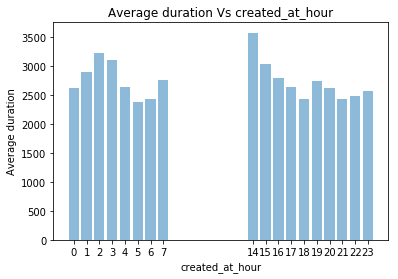

In [328]:
create_plot(duration_by_hour, 'created_at_hour', 'duration')

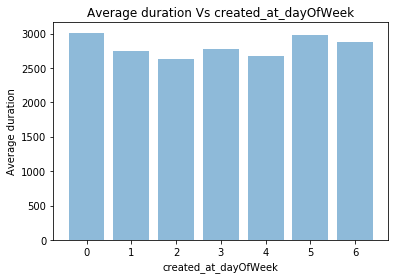

In [329]:
create_plot(duration_by_dayOfWeek, 'created_at_dayOfWeek', 'duration')

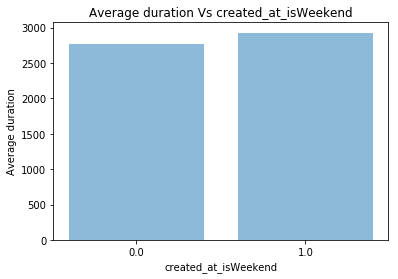

In [330]:
create_plot(duration_by_IsWeekend, 'created_at_isWeekend', 'duration')

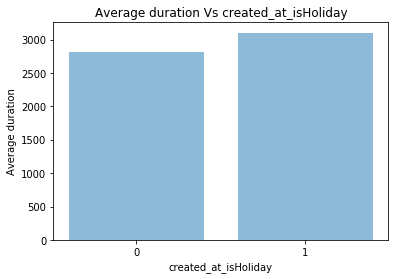

In [331]:
create_plot(duration_by_IsHoliday, 'created_at_isHoliday', 'duration')

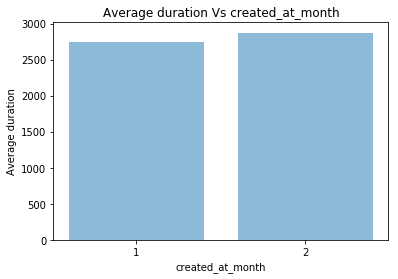

In [332]:
create_plot(duration_by_month, 'created_at_month', 'duration')

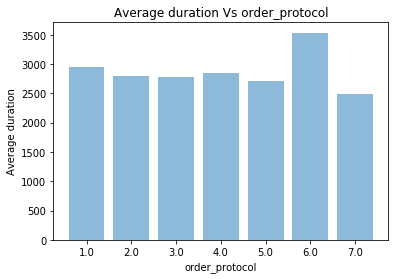

In [333]:
create_plot(duration_by_orderProcotal, 'order_protocol', 'duration')

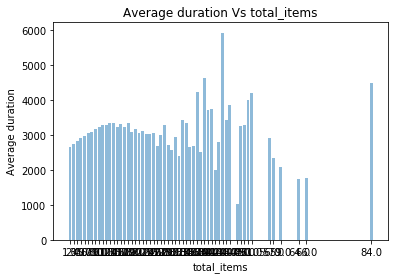

In [334]:
# Total_items = 411 is an outlier
create_plot(duration_by_totalItems[duration_by_totalItems['total_items']<411], 'total_items', 'duration')

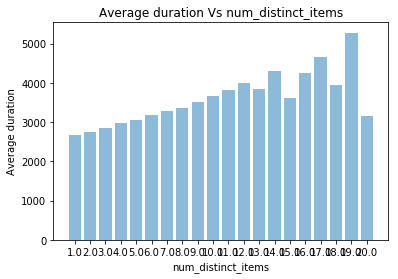

In [336]:
create_plot(duration_by_distinctItems, 'num_distinct_items', 'duration')

### Deal with missing data and outliers

In [390]:
Train['total_items'].quantile(np.arange(0,1.01,0.01))

0.00      1.0
0.01      1.0
0.02      1.0
0.03      1.0
0.04      1.0
0.05      1.0
0.06      1.0
0.07      1.0
0.08      1.0
0.09      1.0
0.10      1.0
0.11      1.0
0.12      1.0
0.13      1.0
0.14      1.0
0.15      1.0
0.16      1.0
0.17      1.0
0.18      1.0
0.19      1.0
0.20      1.0
0.21      2.0
0.22      2.0
0.23      2.0
0.24      2.0
0.25      2.0
0.26      2.0
0.27      2.0
0.28      2.0
0.29      2.0
        ...  
0.71      4.0
0.72      4.0
0.73      4.0
0.74      4.0
0.75      4.0
0.76      4.0
0.77      4.0
0.78      4.0
0.79      4.0
0.80      4.0
0.81      4.0
0.82      5.0
0.83      5.0
0.84      5.0
0.85      5.0
0.86      5.0
0.87      5.0
0.88      5.0
0.89      6.0
0.90      6.0
0.91      6.0
0.92      6.0
0.93      7.0
0.94      7.0
0.95      7.0
0.96      8.0
0.97      9.0
0.98     10.0
0.99     12.0
1.00    411.0
Name: total_items, Length: 101, dtype: float64

In [391]:
Train['subtotal'].quantile(np.arange(0,1.01,0.01))

0.00        0.0
0.01      529.0
0.02      649.0
0.03      710.0
0.04      780.0
0.05      805.0
0.06      850.0
0.07      895.0
0.08      919.0
0.09      950.0
0.10      995.0
0.11     1000.0
0.12     1046.0
0.13     1078.0
0.14     1099.0
0.15     1125.0
0.16     1150.0
0.17     1195.0
0.18     1200.0
0.19     1245.0
0.20     1275.0
0.21     1299.0
0.22     1325.0
0.23     1350.0
0.24     1393.0
0.25     1400.0
0.26     1445.0
0.27     1475.0
0.28     1499.0
0.29     1527.0
         ...   
0.71     3150.0
0.72     3200.0
0.73     3275.0
0.74     3324.0
0.75     3395.0
0.76     3465.0
0.77     3535.0
0.78     3600.0
0.79     3690.0
0.80     3780.0
0.81     3852.0
0.82     3946.0
0.83     4035.0
0.84     4140.0
0.85     4247.0
0.86     4370.0
0.87     4491.0
0.88     4615.0
0.89     4775.0
0.90     4930.0
0.91     5103.2
0.92     5325.0
0.93     5580.0
0.94     5865.8
0.95     6200.0
0.96     6630.0
0.97     7204.4
0.98     8069.2
0.99     9469.0
1.00    27100.0
Name: subtotal, Length: 

In [399]:
Train['num_distinct_items'].value_counts()

2.0     59173
1.0     49838
3.0     41839
4.0     23185
5.0     11772
6.0      5695
7.0      2917
8.0      1419
9.0       734
10.0      389
11.0      233
12.0      105
13.0       60
14.0       35
15.0       13
16.0        6
18.0        3
17.0        2
19.0        2
20.0        1
Name: num_distinct_items, dtype: int64

In [400]:
Train['min_item_price'].quantile(np.arange(0,1.01,0.01))

0.00      -86.0
0.01        0.0
0.02       69.0
0.03       99.0
0.04      100.0
0.05      125.0
0.06      140.0
0.07      150.0
0.08      150.0
0.09      160.0
0.10      175.0
0.11      189.0
0.12      195.0
0.13      199.0
0.14      200.0
0.15      200.0
0.16      225.0
0.17      233.0
0.18      249.0
0.19      250.0
0.20      250.0
0.21      269.0
0.22      275.0
0.23      295.0
0.24      295.0
0.25      299.0
0.26      300.0
0.27      309.0
0.28      325.0
0.29      340.0
         ...   
0.71      895.0
0.72      895.0
0.73      899.0
0.74      907.0
0.75      949.0
0.76      958.0
0.77      995.0
0.78      995.0
0.79      999.0
0.80     1000.0
0.81     1050.0
0.82     1079.0
0.83     1095.0
0.84     1100.0
0.85     1125.0
0.86     1156.2
0.87     1195.0
0.88     1200.0
0.89     1250.0
0.90     1295.0
0.91     1300.0
0.92     1395.0
0.93     1400.0
0.94     1495.0
0.95     1595.0
0.96     1690.0
0.97     1800.0
0.98     2000.0
0.99     2500.0
1.00    14700.0
Name: min_item_price, Le

In [407]:
Train['max_item_price'].quantile(np.arange(0,1.01,0.01))

0.00        0.0
0.01      259.0
0.02      310.8
0.03      359.0
0.04      399.0
0.05      439.0
0.06      479.0
0.07      500.0
0.08      549.0
0.09      579.0
0.10      599.0
0.11      625.0
0.12      649.0
0.13      669.0
0.14      695.0
0.15      699.0
0.16      700.0
0.17      719.0
0.18      729.0
0.19      749.0
0.20      759.0
0.21      780.0
0.22      795.0
0.23      795.0
0.24      799.0
0.25      800.0
0.26      825.0
0.27      845.0
0.28      850.0
0.29      869.0
         ...   
0.71     1300.0
0.72     1347.0
0.73     1365.0
0.74     1395.0
0.75     1395.0
0.76     1400.0
0.77     1400.0
0.78     1450.0
0.79     1475.0
0.80     1495.0
0.81     1499.0
0.82     1500.0
0.83     1550.0
0.84     1595.0
0.85     1600.0
0.86     1619.0
0.87     1675.0
0.88     1698.0
0.89     1700.0
0.90     1795.0
0.91     1800.0
0.92     1895.0
0.93     1930.0
0.94     2000.0
0.95     2099.0
0.96     2249.0
0.97     2403.8
0.98     2695.0
0.99     3077.0
1.00    14700.0
Name: max_item_price, Le

In [428]:
Train['total_onshift_dashers'].value_counts(dropna=False)

NaN       16269
 0.0       3615
 18.0      2924
 15.0      2912
 21.0      2841
 19.0      2824
 10.0      2756
 25.0      2752
 7.0       2752
 24.0      2752
 9.0       2752
 22.0      2747
 20.0      2738
 17.0      2737
 14.0      2733
 6.0       2727
 13.0      2720
 11.0      2719
 23.0      2719
 12.0      2699
 16.0      2691
 4.0       2624
 5.0       2607
 8.0       2579
 27.0      2293
 26.0      2281
 3.0       2212
 28.0      2107
 29.0      2046
 40.0      2002
          ...  
 151.0      113
 139.0      106
 148.0       96
 146.0       96
 145.0       95
 149.0       86
 143.0       72
 147.0       53
 153.0       47
 156.0       35
 150.0       30
 157.0       29
 152.0       28
 154.0       21
 155.0       21
 142.0       20
 158.0       19
-2.0         13
 160.0        9
-1.0          6
 168.0        1
 171.0        1
 169.0        1
 165.0        1
 159.0        1
 163.0        1
-4.0          1
-3.0          1
 164.0        1
 162.0        1
Name: total_onshift_dash

In [404]:
Train['total_busy_dashers'].value_counts(dropna=False)

NaN       16269
 0.0       4171
 10.0      3114
 13.0      3052
 6.0       3040
 18.0      3001
 11.0      2981
 8.0       2977
 12.0      2954
 16.0      2935
 9.0       2934
 5.0       2930
 7.0       2923
 15.0      2920
 14.0      2916
 17.0      2868
 4.0       2841
 19.0      2789
 23.0      2718
 3.0       2644
 24.0      2610
 20.0      2563
 21.0      2556
 22.0      2547
 25.0      2292
 2.0       2286
 26.0      2207
 27.0      2099
 28.0      2063
 29.0      2045
          ...  
 127.0      186
 130.0      152
 131.0      121
 132.0      112
 136.0       84
 137.0       80
 138.0       64
 135.0       48
 142.0       45
 134.0       41
 133.0       40
 145.0       36
 148.0       31
 141.0       31
 146.0       29
 143.0       25
 139.0       23
-1.0         13
 144.0        8
 140.0        7
 147.0        7
-2.0          3
 152.0        2
 150.0        2
-3.0          2
-4.0          2
 149.0        1
 154.0        1
 153.0        1
-5.0          1
Name: total_busy_dashers

In [408]:
Train['total_outstanding_orders'].value_counts(dropna=False)

NaN       16269
 0.0       4111
 9.0       2744
 10.0      2705
 8.0       2685
 6.0       2672
 7.0       2621
 13.0      2618
 11.0      2586
 18.0      2566
 12.0      2559
 5.0       2559
 14.0      2516
 4.0       2486
 15.0      2460
 20.0      2433
 16.0      2390
 17.0      2379
 3.0       2334
 19.0      2316
 21.0      2290
 22.0      2267
 25.0      2249
 23.0      2228
 24.0      2111
 2.0       2079
 26.0      2014
 27.0      1916
 29.0      1896
 28.0      1886
          ...  
 262.0       17
 237.0       17
-1.0         16
 258.0       16
 242.0       14
 274.0       14
 244.0       13
 249.0       13
 219.0       12
 224.0       12
 257.0       11
-3.0          8
 206.0        7
 233.0        6
-2.0          6
 227.0        6
-5.0          6
-6.0          5
-4.0          3
 241.0        3
 259.0        2
 264.0        1
 245.0        1
 268.0        1
 285.0        1
 277.0        1
 273.0        1
 283.0        1
 265.0        1
 260.0        1
Name: total_outstanding_